# Plotting

In this notebook, I'll develop a function to plot subjects and their labels.

In [1]:
from astropy.coordinates import SkyCoord
import astropy.io.fits
import astropy.wcs
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy
import skimage.exposure
import sklearn.neighbors
import sklearn.pipeline
import sklearn.preprocessing

CROWDASTRO_H5_PATH = 'data/crowdastro.h5'
PATCH_DIAMETER = 200
FITS_CONVENTION = 1
ARCMIN = 1 / 60
IMAGE_SIZE = 200 * 200
NORRIS_DAT_PATH = 'data/norris_2006_atlas_classifications_ra_dec_only.dat'
TRAINING_H5_PATH = 'data/training.h5'

with h5py.File(CROWDASTRO_H5_PATH, 'r') as f_h5:
    N_ASTRO = 5 if f_h5.attrs['ir_survey'] == 'wise' else 6

%matplotlib inline

## Displaying radio images

Radio images look pretty terrible, so let's run a filter over them to make them a little easier to see. I'll use skimage and try a few different ones.

Let's get an example and look at the basic output.

In [2]:
with h5py.File(CROWDASTRO_H5_PATH, 'r') as f_h5:
    image = f_h5['/atlas/cdfs/numeric'][250, 2 : 2 + PATCH_DIAMETER ** 2].reshape((PATCH_DIAMETER, PATCH_DIAMETER))

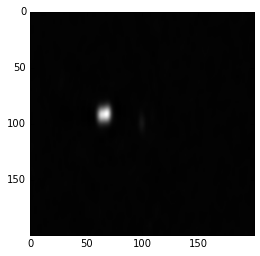

In [3]:
plt.imshow(image, cmap='gray')
plt.show()

It's hard to make out any features. Now, let's run some filters on it.

K:\Languages\Python35_64\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


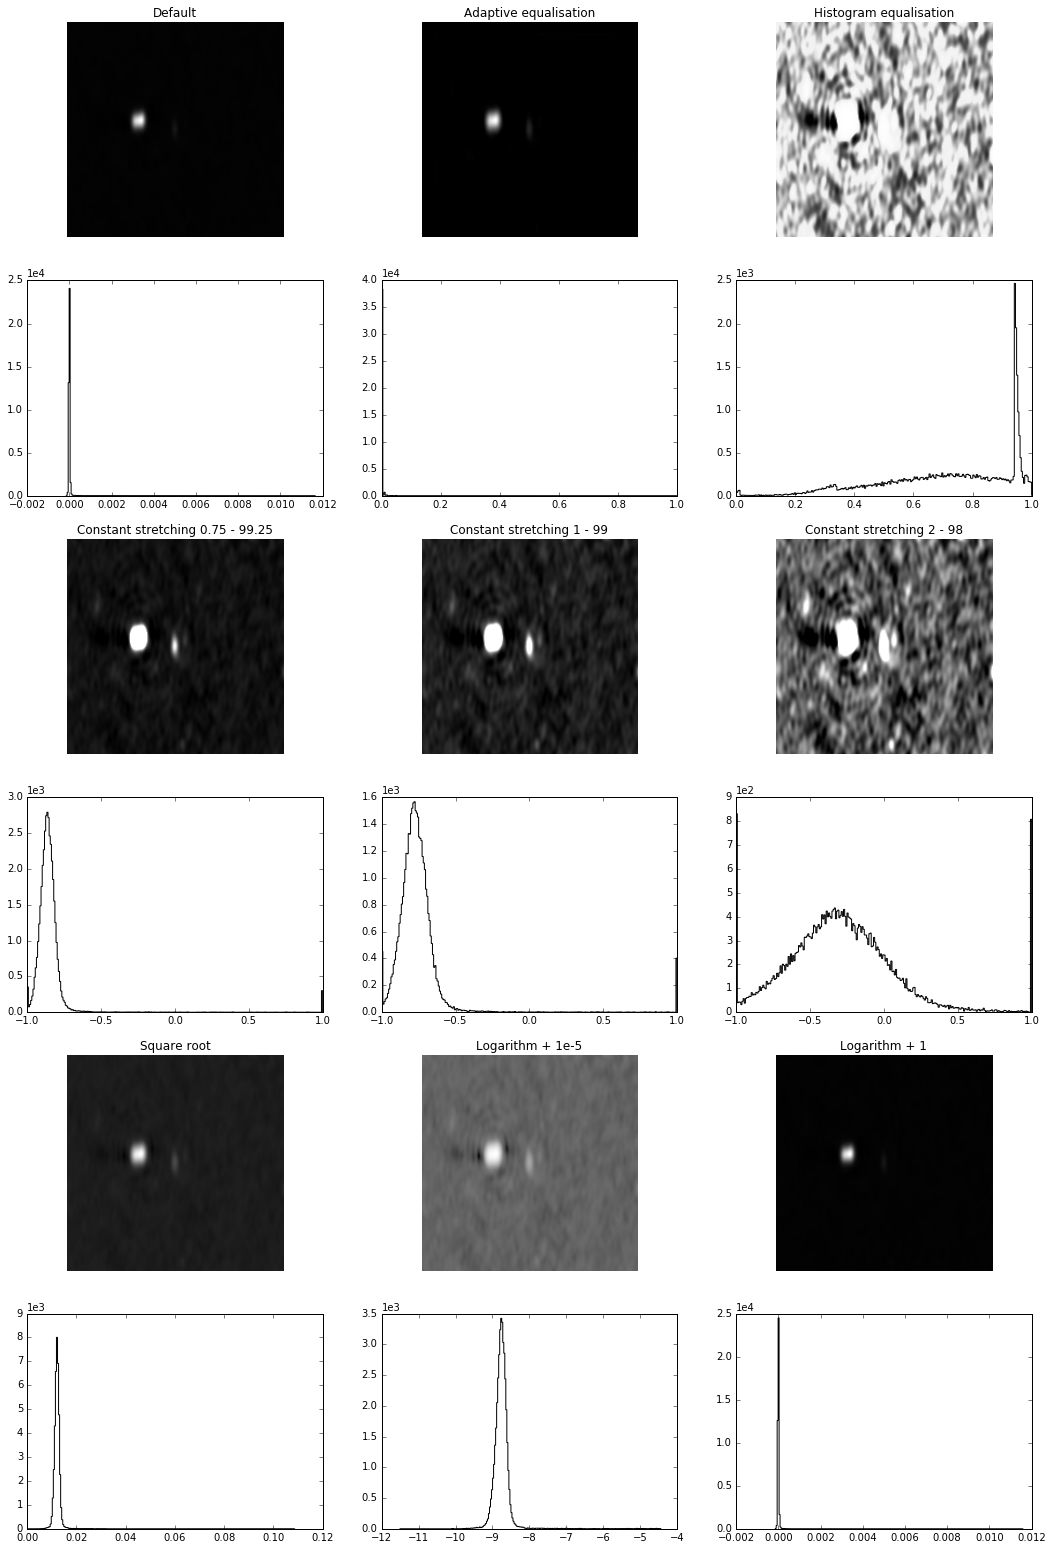

In [4]:
fig = plt.figure(figsize=(18, 27))

def subplot_imshow_hist(i, fig, im, title):
    ax = fig.add_subplot(6, 3, i)
    ax.imshow(im, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
    
    ax = fig.add_subplot(6, 3, i + 3)
    ax.hist(im.ravel(), bins=256, histtype='step', color='black')
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

subplot_imshow_hist(1, fig, image, 'Default')

subplot_imshow_hist(2, fig, skimage.exposure.equalize_adapthist(image, clip_limit=0.01), 'Adaptive equalisation')

subplot_imshow_hist(3, fig, skimage.exposure.equalize_hist(image), 'Histogram equalisation')

subplot_imshow_hist(7, fig, skimage.exposure.rescale_intensity(image, in_range=tuple(numpy.percentile(image, (0.75, 99.25)))),
                    'Constant stretching 0.75 - 99.25')

subplot_imshow_hist(8, fig, skimage.exposure.rescale_intensity(image, in_range=tuple(numpy.percentile(image, (1, 99)))),
                    'Constant stretching 1 - 99')

subplot_imshow_hist(9, fig, skimage.exposure.rescale_intensity(image, in_range=tuple(numpy.percentile(image, (2, 98)))),
                    'Constant stretching 2 - 98')

subplot_imshow_hist(13, fig, numpy.sqrt(image - image.min()), 'Square root')

subplot_imshow_hist(14, fig, numpy.log(image - image.min() + 1e-5), 'Logarithm + 1e-5')

subplot_imshow_hist(15, fig, numpy.log(image + 1), 'Logarithm + 1')



Square root looks good, so let's blitz that over some random images and see how it looks.

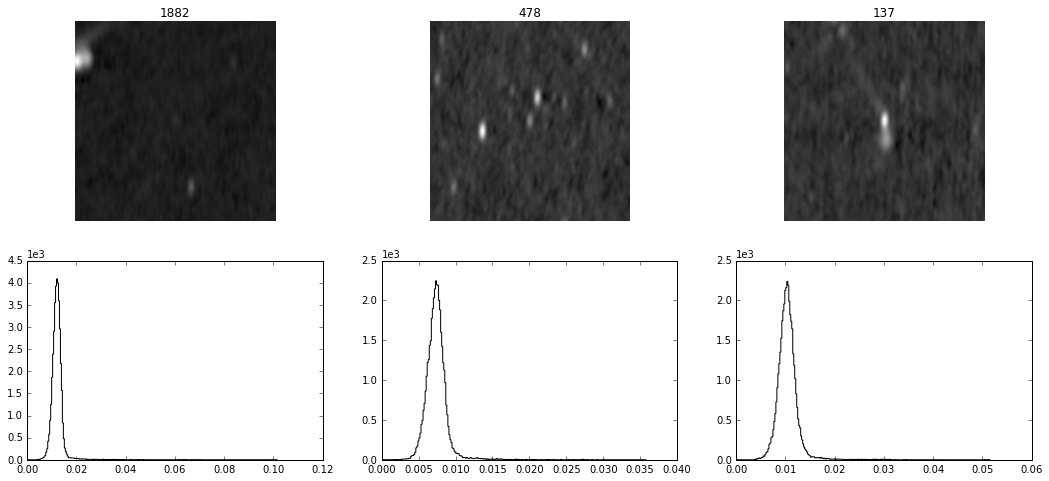

In [5]:
fig = plt.figure(figsize=(18, 25))

with h5py.File(CROWDASTRO_H5_PATH, 'r') as f_h5:
    indices = numpy.arange(f_h5['/atlas/cdfs/numeric'].shape[0])
    numpy.random.seed(10000)
    numpy.random.shuffle(indices)
    
    for j, i in enumerate(indices[:3]):
        image = f_h5['/atlas/cdfs/numeric'][i, 2 : 2 + PATCH_DIAMETER ** 2].reshape((PATCH_DIAMETER, PATCH_DIAMETER))
        subplot_imshow_hist(j + 1, fig, numpy.sqrt(image - image.min()), str(i))

## Plotting IR objects

This is an extremely unpleasant operation: We have to find the pixel coordinates of each IR location, which are all specified in RA/DEC.

In [6]:
from crowdastro.config import config

with astropy.io.fits.open(config['data_sources']['atlas_image'],
                          ignore_blank=True) as atlas_image:
    wcs = astropy.wcs.WCS(atlas_image[0].header).dropaxis(3).dropaxis(2)

def ra_dec_to_pixels(subject_coords, coords):
    offset, = wcs.all_world2pix([subject_coords], FITS_CONVENTION)
    # The coords are of the middle of the subject.
    coords = wcs.all_world2pix(coords, FITS_CONVENTION)
    coords -= offset
    
    coords[:, 0] /= config['surveys']['atlas']['mosaic_scale_x'] * 424 / 200
    coords[:, 1] /= config['surveys']['atlas']['mosaic_scale_y'] * 424 / 200
    
    coords += [40, 40]
    
    return coords

K:\Languages\Python35_64\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '


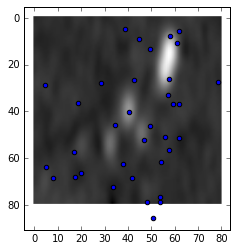

In [7]:
with h5py.File(CROWDASTRO_H5_PATH, 'r') as f_h5:
    i = 296
    image = f_h5['/atlas/cdfs/numeric'][i, 2 : 2 + PATCH_DIAMETER ** 2].reshape(
            (PATCH_DIAMETER, PATCH_DIAMETER))[60:140, 60:140]
    radio_coords = f_h5['/atlas/cdfs/numeric'][i, :2]
    nearby = f_h5['/atlas/cdfs/numeric'][i, 2 + PATCH_DIAMETER ** 2:] < ARCMIN
    ir_coords = f_h5['/swire/cdfs/numeric'][nearby, :2]
    ir_coords = ra_dec_to_pixels(radio_coords, ir_coords)
    
    plt.imshow(numpy.sqrt(image - image.min()), cmap='gray')
    plt.scatter(ir_coords[:, 0], ir_coords[:, 1])

## Displaying classifications

The simplest thing we can do is to just highlight the host galaxies, so let's load up the Norris et al. classifications and have a look.

In [8]:
# Load labels.

with h5py.File(TRAINING_H5_PATH, 'r') as training_h5:
    crowdsourced_labels = training_h5['labels'].value

with h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    ir_names = crowdastro_h5['/swire/cdfs/string'].value
    ir_positions = crowdastro_h5['/swire/cdfs/numeric'].value[:, :2]
ir_tree = sklearn.neighbors.KDTree(ir_positions)

with open(NORRIS_DAT_PATH, 'r') as norris_dat:
    norris_coords = [r.strip().split('|') for r in norris_dat]

norris_labels = numpy.zeros((len(ir_positions)))
for ra, dec in norris_coords:
    # Find a neighbour.
    skycoord = SkyCoord(ra=ra, dec=dec, unit=('hourangle', 'deg'))
    ra = skycoord.ra.degree
    dec = skycoord.dec.degree
    ((dist,),), ((ir,),) = ir_tree.query([(ra, dec)])
    if dist < 0.1:
        norris_labels[ir] = 1

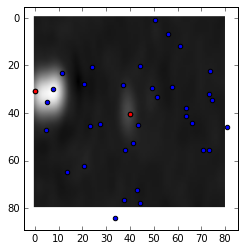

In [9]:
with h5py.File(CROWDASTRO_H5_PATH, 'r') as f_h5:
    i = 250
    image = f_h5['/atlas/cdfs/numeric'][i, 2 : 2 + PATCH_DIAMETER ** 2].reshape(
            (PATCH_DIAMETER, PATCH_DIAMETER))[60:140, 60:140]
    radio_coords = f_h5['/atlas/cdfs/numeric'][i, :2]
    nearby = f_h5['/atlas/cdfs/numeric'][i, 2 + PATCH_DIAMETER ** 2:] < ARCMIN
    ir_coords = f_h5['/swire/cdfs/numeric'][nearby, :2]
    ir_coords = ra_dec_to_pixels(radio_coords, ir_coords)
    
    plt.imshow(numpy.sqrt(image - image.min()), cmap='gray')
    plt.scatter(ir_coords[:, 0], ir_coords[:, 1])
    
    labels = norris_labels[nearby].astype(bool)
    nearby_hosts = ir_coords[labels]
    plt.scatter(nearby_hosts[:, 0], nearby_hosts[:, 1], c='red')

What about displaying classifications from my classifier?

In [10]:
from crowdastro.classifier import RGZClassifier

from sklearn.ensemble import RandomForestClassifier

In [11]:
with h5py.File(TRAINING_H5_PATH, 'r') as f_h5:
    classifier = RGZClassifier(f_h5['features'].value, N_ASTRO)
    
    classifier.train(numpy.arange(f_h5['features'].shape[0]), norris_labels)

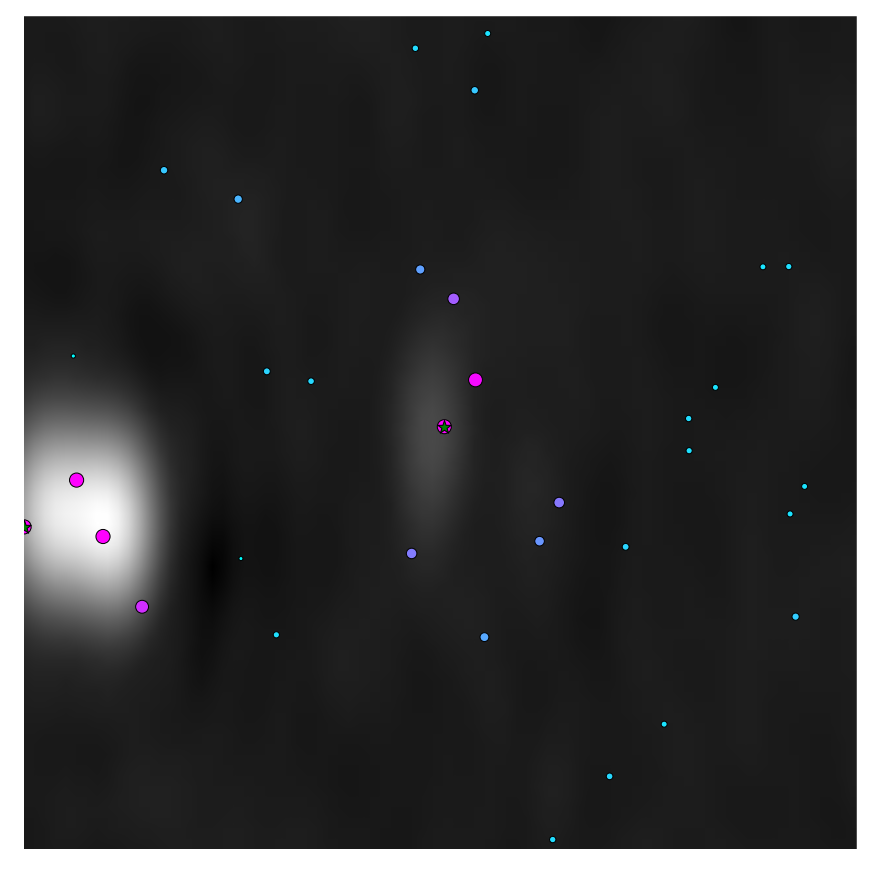

In [12]:
with h5py.File(CROWDASTRO_H5_PATH, 'r') as f_h5:
    i = 250
    image = f_h5['/atlas/cdfs/numeric'][i, 2 : 2 + PATCH_DIAMETER ** 2].reshape(
            (PATCH_DIAMETER, PATCH_DIAMETER))[60:140, 60:140]
    radio_coords = f_h5['/atlas/cdfs/numeric'][i, :2]
    nearby = f_h5['/atlas/cdfs/numeric'][i, 2 + PATCH_DIAMETER ** 2:] < ARCMIN
    ir_coords = f_h5['/swire/cdfs/numeric'][nearby, :2]
    ir_coords = ra_dec_to_pixels(radio_coords, ir_coords)
    vec = f_h5['/atlas/cdfs/numeric'][i, :]
    
    probs = classifier.predict_probabilities(vec)[nearby]
    nearby_norris = ir_coords[norris_labels[nearby].astype('bool')]
    nearby_rgz = ir_coords[crowdsourced_labels[nearby].astype('bool')]
    
    plt.figure(figsize=(15, 15))
    base_size = 200
    plt.imshow(numpy.sqrt(image - image.min()), cmap='gray')
    plt.scatter(ir_coords[:, 0], ir_coords[:, 1], s=probs * base_size, c=probs, marker='o', cmap='cool')
    plt.scatter(nearby_norris[:, 0], nearby_norris[:, 1], s=base_size, c='green', marker='*')
    plt.axis('off')
#     plt.scatter(nearby_rgz[:, 0], nearby_rgz[:, 1], s=50, c='cyan', marker='x', alpha=0.5)
    plt.xlim((0, 80))
    plt.ylim((0, 80))

## Plotting a committee

If we have multiple classifiers, how should we output their predictions?

In [13]:
with h5py.File(TRAINING_H5_PATH, 'r') as f_h5:
    classifiers = [RGZClassifier(f_h5['features'], N_ASTRO) for _ in range(10)]
    
    for classifier in classifiers:
        subset = numpy.arange(f_h5['features'].shape[0])
        numpy.random.shuffle(subset)
        subset = subset[:len(subset) // 50]
        subset = sorted(subset)
        classifier.train(list(subset), norris_labels[subset])
        
    with h5py.File(CROWDASTRO_H5_PATH, 'r') as f_h5:
        i = 250
        image = f_h5['/atlas/cdfs/numeric'][i, 2 : 2 + PATCH_DIAMETER ** 2].reshape(
                (PATCH_DIAMETER, PATCH_DIAMETER))[60:140, 60:140]
        radio_coords = f_h5['/atlas/cdfs/numeric'][i, :2]
        nearby = f_h5['/atlas/cdfs/numeric'][i, 2 + PATCH_DIAMETER ** 2:] < ARCMIN
        ir_coords = f_h5['/swire/cdfs/numeric'][nearby, :2]
        ir_coords = ra_dec_to_pixels(radio_coords, ir_coords)
        vec = f_h5['/atlas/cdfs/numeric'][i, :]

        probs = [classifier.predict_probabilities(vec)[nearby] for classifier in classifiers]
        # Set all but the top n predictions to zero.
        n = 1
        for probs_ in probs:
            top_n = sorted(probs_, reverse=True)[:n]
            for j, prob in enumerate(probs_):
                if prob not in top_n:
                    probs_[j] = 0

(0, 80)

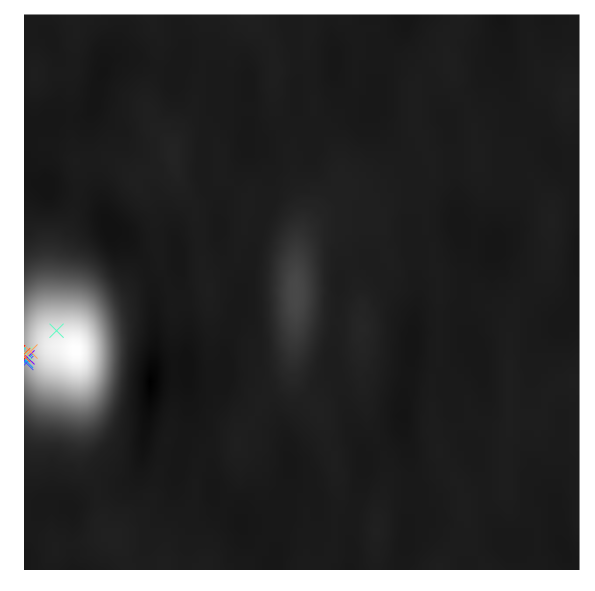

In [14]:
plt.figure(figsize=(10, 10))
base_size = 200
plt.imshow(numpy.sqrt(image - image.min()), cmap='gray')

colours = cm.rainbow(numpy.linspace(0, 1, 10))

for colour, probs_ in zip(colours, probs):
    plt.scatter(ir_coords[:, 0] + numpy.random.normal(size=ir_coords.shape[0], scale=0.5),
                ir_coords[:, 1] + numpy.random.normal(size=ir_coords.shape[0], scale=0.5),
                s=probs_ * base_size, marker='x', c=colour, alpha=1)
plt.axis('off')
plt.xlim((0, 80))
plt.ylim((0, 80))

These classifiers have really low diversity because of the way I divided up the data, but this should work fine.

In [48]:
def plot_points_on_background(points, background, noise=False, base_size=200):
    plt.imshow(background, cmap='gray')

    colours = cm.rainbow(numpy.linspace(0, 1, len(points)))
    for colour, (x, y) in zip(colours, points):
        if noise:
            x += numpy.random.normal(scale=0.5)
            y += numpy.random.normal(scale=0.5)
        plt.scatter(x, y, marker='o', c=colour, s=base_size)
    plt.axis('off')
    plt.xlim((0, background.shape[0]))
    plt.ylim((0, background.shape[1]))

In [43]:
def plot_classifications(atlas_vector, ir_matrix, labels, base_size=200):
    image = atlas_vector[2 : 2 + PATCH_DIAMETER ** 2].reshape((PATCH_DIAMETER, PATCH_DIAMETER)
                                                             )[60:140, 60:140]
    radio_coords = atlas_vector[:2]

    nearby = atlas_vector[2 + PATCH_DIAMETER ** 2:] < ARCMIN
    labels = labels[nearby]

    ir_coords = ir_matrix[nearby, :2][labels.astype(bool)]
    ir_coords = ra_dec_to_pixels(radio_coords, ir_coords)
    
    plot_points_on_background(ir_coords, image, base_size=base_size)

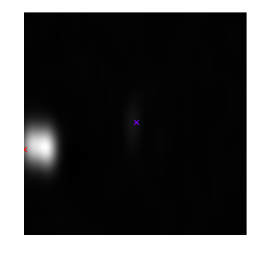

In [28]:
with h5py.File(CROWDASTRO_H5_PATH, 'r') as f_h5:
    i = 250
    atlas_vector = f_h5['/atlas/cdfs/numeric'][i, :]
    ir_coords = f_h5['/swire/cdfs/numeric']
    plot_classifications(atlas_vector, ir_coords, norris_labels)

## Bringing it all together

We want to plot classifications, RGZ labels, and Norris labels in the same row.

In [44]:
def plot_classifications_row(atlas_vector, ir_matrix, classifier_labels, rgz_labels, norris_labels, base_size=200):
    plt.subplot(1, 3, 1)
    plt.title('Classifier')
    plot_classifications(atlas_vector, ir_matrix, classifier_labels, base_size=base_size)
    
    plt.subplot(1, 3, 2)
    plt.title('RGZ')
    plot_classifications(atlas_vector, ir_matrix, rgz_labels, base_size=base_size)
    
    plt.subplot(1, 3, 3)
    plt.title('Norris')
    plot_classifications(atlas_vector, ir_matrix, norris_labels, base_size=base_size)

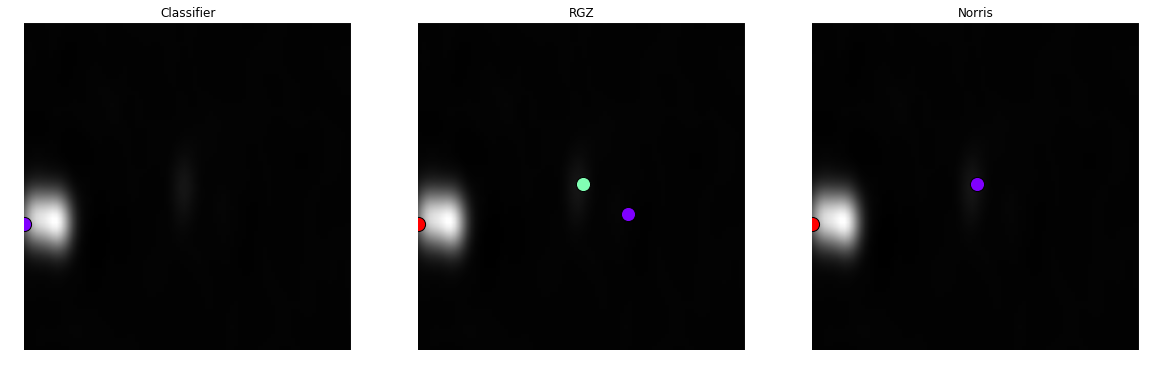

In [49]:
with h5py.File(TRAINING_H5_PATH, 'r') as f_h5:
    classifier = RGZClassifier(f_h5['features'].value, N_ASTRO)
    classifier.train(numpy.arange(f_h5['features'].shape[0]), norris_labels)

with h5py.File(CROWDASTRO_H5_PATH, 'r') as f_h5:
    i = 250
    vec = f_h5['/atlas/cdfs/numeric'][i, :]
    mat = f_h5['/swire/cdfs/numeric']
    probs = classifier.predict_probabilities(vec)
    labels = numpy.zeros(probs.shape)
    labels[probs.argmax()] = 1
    
    plt.figure(figsize=(20, 10))
    plot_classifications_row(vec, mat, labels, crowdsourced_labels, norris_labels, base_size=200)